## ECOSTRESS Data in Python

[ECOSTRESS](https://www.nasa.gov/mission_pages/ecostress/overview), which stands for ECOsystem Spaceborne Thermal Radiometer Experiment on Space Station, is a radiometer that has been attached to the International Space Station since 2018, and collects temperature data on plants. This data can be used to monitor plant life and sense how much water they are releasing to manage their temperature. From this data, we can derive evapotransporation (ET), the Evaporative Stress Index, and calculate the water use efficiency of different areas. 

The raw data from this sensor can be difficult to deal with. It comes in h5 format like GEDI data does, but has a very different way of extracting the relevant information. [NASA built a tool](https://git.earthdata.nasa.gov/projects/LPDUR/repos/ecostress_swath2grid/browse) for users to use so that they can import any of the bands they want, alongside the geospatial band of the sensor, and create a much more familiar geotiff. The format for changing the file format of the downloaded data is shown below.

![](https://drive.google.com/uc?id=1FPGwjQmVMo5umfzDZD3N3v6hxcELBOpR)

## Types of ECOSTRESS Data

The list of ECOSTRESS products, their names, and the data stored in them can be found [here](https://ecostress.jpl.nasa.gov/data/science-data-products-summary-table), with additional details being shown [here](https://ecostress.jpl.nasa.gov/data/user-guide-documents-table). 

ECOSTRESS, like many remote sensors, has different levels of data that have been cleaned up and made ready for analysis as you get to higher levels. The level 1 data will be raw data, or close to raw data, collected by the satellite that hasn't had many corrections or quality checks ran on it, if any at all. For ECOSTRESS, they provide raw radiance data, geolocation data, and other metadata such as the attitude the images were taken at. Thankfully, while these can be useful, NASA also provides products that combine this data with other data sources to run quality checks and corrections, and then use that to calculate different types of scientific data.  

We will be using the PT-JPL ET product NASA provides. There are three different ET products made from the ECOSTRESS data, all of them differing by using competing algorithms to calculate the ET. The product we chose uses the Priestley-Taylor Jet Propulsion Laboratory alogrithm. Within this, there are different bands that contain different information. A description of the data in each band is below, the band that contains the ET data at the canopy level is what we'll use to compare to GEDI data.

![](https://drive.google.com/uc?id=1vHtH6AuXkqJpPY2eLuXJNttmGQfzCHpH)

For this exercise, we acquired one of the ET products (ECO3ETPTJPL.001) alongside the geospatial product (ECO1BGEO.001) and ran them both through the tool NASA made to create a geotiff.

We'll be opening the transformed data, exploring it, then combining it with the GEDI data to do a cross sensor analysis. 

In [1]:
# Import Packages

# Import the required libraries

import os
from os import path
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import rasterio as rio
import earthpy as et
import earthpy.plot as ep
from rasterio.plot import plotting_extent
from shapely.geometry import box
import seaborn as sns


In [2]:
# Get working directory

data_path = os.path.join(et.io.HOME, "GitHub", "ecostress_swath2grid")

## Using `rioxarray` to open raster data

`rioxarray` is a package built on top of `xarray`, a powerful tool that can be used to handle raster data in many formats in Python. While there are many packages that can be used to do similar things, such as `rasterio` or `h5py`, one of the advantages of `rioxarray` is it's ability to open up many types of files easily, such as `.tif`, `.h5`, and `.netcdf` file, all of which are common file types in geospatial analysis. Here we use it to open up the `.tif` file, which we can then clip, access the data from, and plot. For more information on using `rioxarray` in Python, see our lesson [here](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python-xarray/).

In [3]:
# Create path to data
rcew_boundary = gpd.read_file(path.join(data_path, 'shape_data', 'Hay_sch_polys.geojson')) 
ecostress_path = path.join(data_path, 'output', "ECOSTRESS_L3_ET_PT-JPL_23611_012_20220904T134321_0601_01_ETcanopy_GEO.tif")
# Open and clip the data, cliping it to the study area boundary
ecostress = rxr.open_rasterio(ecostress_path).rio.clip(rcew_boundary.geometry)
# Create plotting extent to plot data together
ecostress_extent = plotting_extent(ecostress[0], ecostress.rio.transform())
# GEDI Data
GEDI_path = path.join(data_path, 'shape_data', 'GEDI_4A_Hayman.geojson')
GEDI_data = gpd.read_file(GEDI_path)

## Plot the data

Now that we've opened up the data, we can plot it in the Hayman fire bounds and see how it overlaps with our GEDI data from there. 

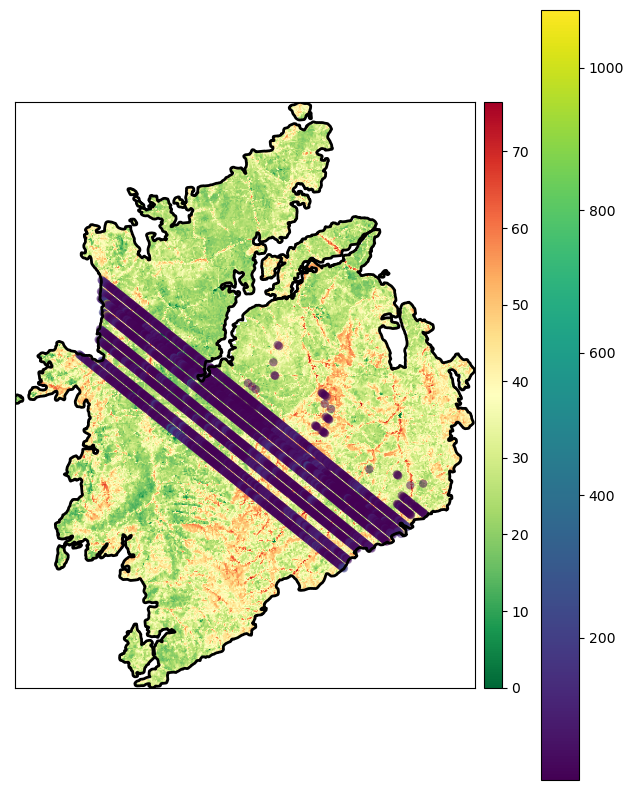

In [4]:
# Plot the GEDI and ECOSTRESS data together!
fig, ax = plt.subplots(figsize=(10,10))
ep.plot_bands(ecostress, ax=ax, cmap='RdYlGn_r', extent=ecostress_extent)
rcew_boundary.geometry.boundary.plot(ax=ax, edgecolor='black', linewidth=2)
GEDI_data.plot(ax=ax, column='agbd', linewidth=0, legend=True, alpha = 0.5)
plt.show()

## Extract ECOSTRESS raster data to GEDI points

Below are two functions that will extract the point values from a raster. We can use these to get the ECOSTRESS data at the points where we have GEDI data, and combine them into one dataset we can use to see the amount of aboveground biomass (AGBD) and ET together. This is a great way to enhance GEDI data with other datasets, and values like this could be extracted from rasters such as slope, aspect, or elevation. 

GEDI data is collected in circles with a 25 meter diameter over multiple passes, where as the ECOSTRESS data is collected in much wider images. The functions below use the centerpoint of the GEDI footprint to determine which ECOSTRESS value to extract from the raster, using esentially a nearest neighbor approach. We do this instead of interpolating data to avoid using data that was never actually collected. 

In [5]:
def extract_points(raster_path, points):
    """
    Get values of raster at series of points

    Parameters
    ----------
    raster_path: path variable
        Path to the raster to extract data from

    points: GeoDataframe
        List of points to use when extracting data from raster

    Returns
    -------
    values : list
        A list of values at each point from the raster
    """
    # Open raster
    raster = rio.open(raster_path)
    values = []
    # Create a bounding box for the raster and clip the points to that
    points_clip = points.clip(box(*raster.bounds))
    point_num = len(points_clip)
    array = raster.read()
    # Loop through points, get the value of the raster at each xy
    for point in points_clip['geometry']:
        x, y = point.xy[0][0], point.xy[1][0]
        row, col = raster.index(x,y)
        attrs = []
        band_nums = array.shape[0]
        for z in range(band_nums):
            # Looping through all bands
            attrs.append(array[z, row,col])
            values.append([attrs, point])
    # Close raster
    raster.close()
    return(values)

def turn_raster_output_to_gdf(raster_path, points):
    """
    Get values of raster at series of points and turn the values into a GeoDataFrame

    Parameters
    ----------
    raster_path: path variable
        Path to the raster to extract data from

    points: GeoDataframe
        List of points to use when extracting data from raster

    Returns
    -------
    GeoDataFrame
        A GeoDataFrame containing all the points and the values from the raster at each point
    """
    # Runs extract_points
    extracted_vals = extract_points(raster_path, points)
    # Turn output into dataframe
    output_pd = pd.DataFrame(extracted_vals)
    lis = output_pd[0].to_list()
    geom = output_pd[1].to_list()
    # Turn output into labeled
    org = pd.DataFrame(lis, columns = ["ETPT"])
    # read points into geodataframe
    return(gpd.GeoDataFrame(org, geometry=geom, crs=points.crs))

In [6]:
# Extracting values from raster
points_with_values = turn_raster_output_to_gdf(ecostress_path, GEDI_data)
# Running a spatial join on the GEDI data and the data gotten from ECOSTRESS. Dropping unnecessary indices and na values. 
ETPT_agbd = gpd.sjoin(GEDI_data, points_with_values).reset_index().drop(columns=['index_right', 'index'], axis=1).dropna()   

## Display the combined datasets.

Now that we've extracted the values and ran a spatial join, we can see the results using `.head()` in `pandas`. 

In [7]:
# Display dataframe with combined data!
ETPT_agbd.head()

,lat_lowestmode,lon_lowestmode,agbd,geometry,ETPT
0,39.183799,-105.249182,0.410315,POINT (-105.24918 39.18380),44.461845
1,39.183156,-105.248157,0.624369,POINT (-105.24816 39.18316),41.935349
2,39.156759,-105.217061,1.391625,POINT (-105.21706 39.15676),58.501953
3,39.156436,-105.216546,1.061925,POINT (-105.21655 39.15644),46.615067
4,39.156113,-105.216035,2.221455,POINT (-105.21603 39.15611),46.615067


## Plotting our data against each other

Here, we can plot our ET data against the AGBD data to see if there's any sort of correlation between the two! It's important to keep in mind when comparing datasets like this any issues that may come from comparing them directly. For example, the fact that the GEDI data is collected over multiple days and aggregated means that comparing it to data collected in a single day, like ECOSTRESS, may not provide the results you are looking for. 

Here, we will drop outliers from the dataset using the `.quantile()` method in `pandas`, then plot the ET data against the AGBD data using the `seaborn` library, using a function called `.lmplot()`. This will plot the two variables against each other and draw a linear regression as well. 

In [8]:
# Getting values for outliers

upper_outlier_agbd, lower_outlier_agbd = ETPT_agbd.agbd.quantile(.98), ETPT_agbd.agbd.quantile(.2)
upper_outlier_ETPT, lower_outlier_ETPT = ETPT_agbd.agbd.quantile(.98), ETPT_agbd.agbd.quantile(.2)

# Removing outliers from dataset
ETPT_agbd_no_outliers = ETPT_agbd[(ETPT_agbd.agbd < upper_outlier_agbd) & 
                                  (ETPT_agbd.agbd > lower_outlier_agbd) & 
                                  (ETPT_agbd.ETPT < upper_outlier_ETPT) & 
                                  (ETPT_agbd.ETPT > lower_outlier_ETPT)]

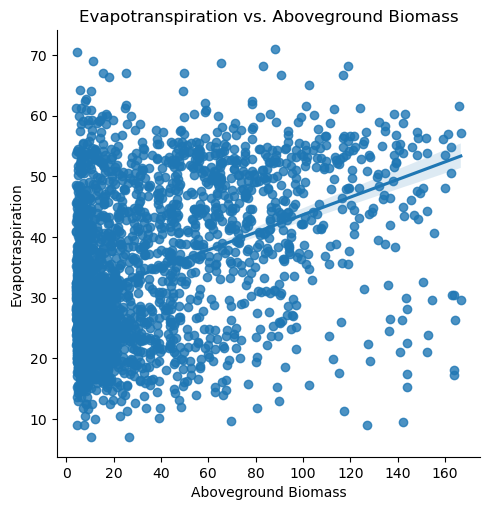

In [9]:
# Plotting the variables and the linear regression

sns.lmplot(x='agbd', y='ETPT', data=ETPT_agbd_no_outliers, fit_reg=True) 
ax = plt.gca()
ax.set(title="Evapotranspiration vs. Aboveground Biomass",
       xlabel="Aboveground Biomass",
       ylabel = "Evapotraspiration")

plt.show()